# Setup

In [1]:
!pip install minari

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.2 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from collections import deque

import minari
import random

from IPython.display import Video

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
!mkdir videos

In [5]:
env = gym.make('BreakoutNoFrameskip-v4', obs_type='rgb', render_mode='rgb_array')
env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=True, frame_skip=4, terminal_on_life_loss=True, scale_obs=True)
env = gym.wrappers.RecordVideo(env, video_folder="videos/", name_prefix="breakout_test")
env = gym.wrappers.FrameStackObservation(env, 4)  # stack 4 consecutive frames

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


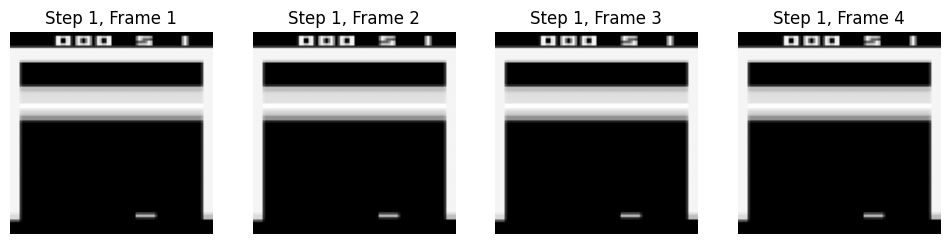

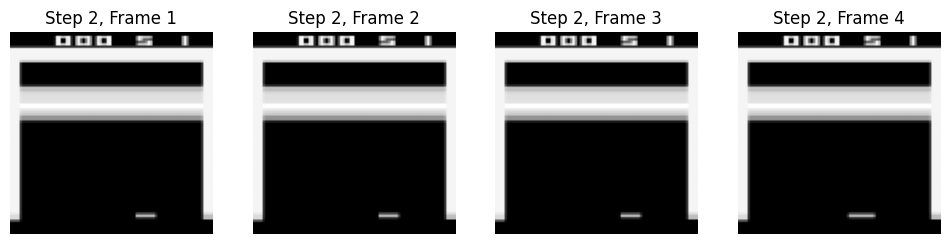

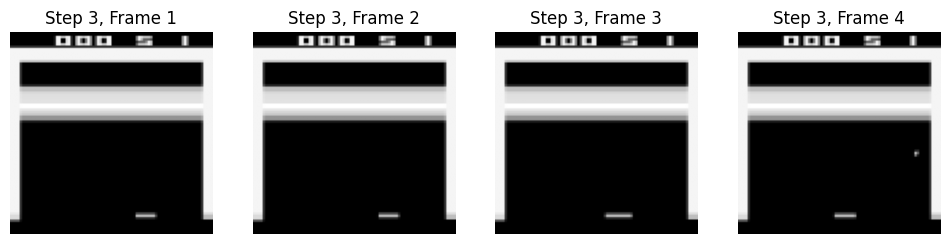

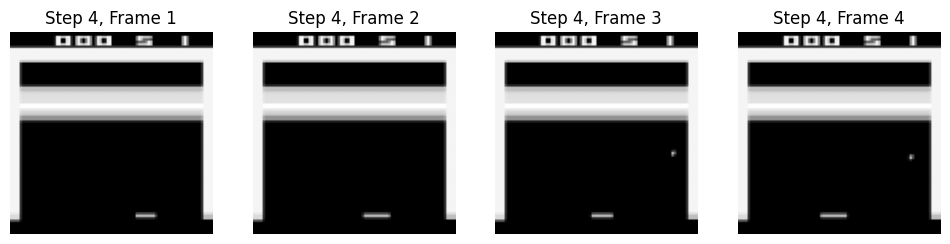

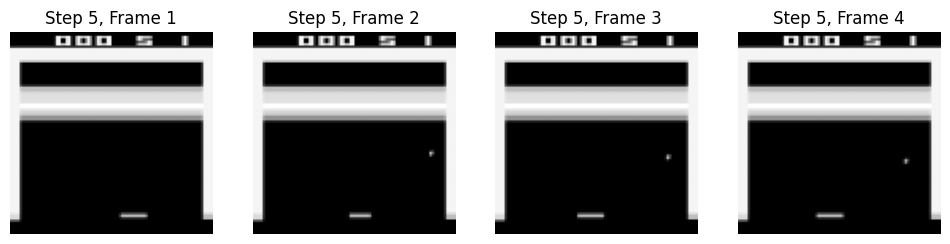

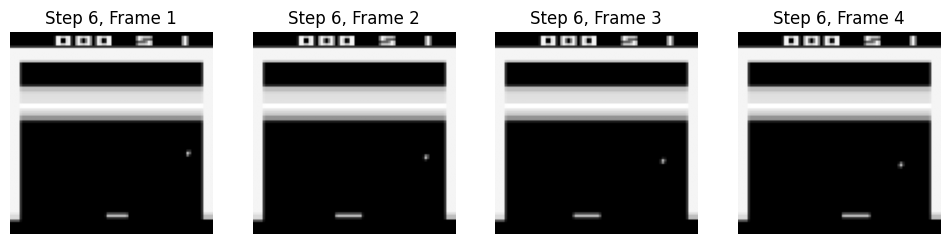

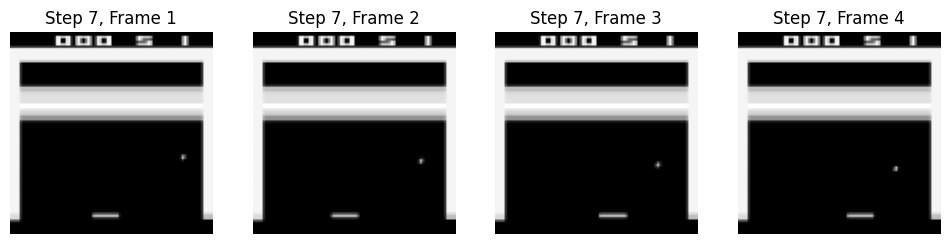

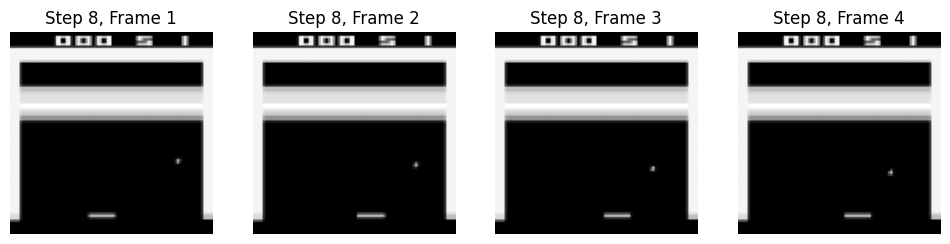

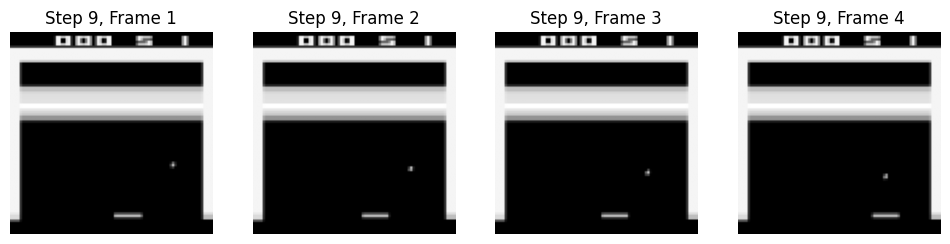

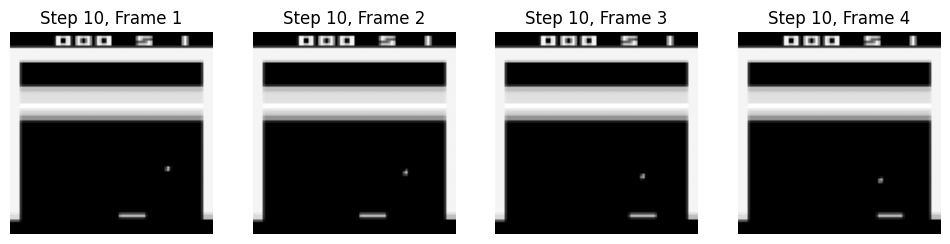

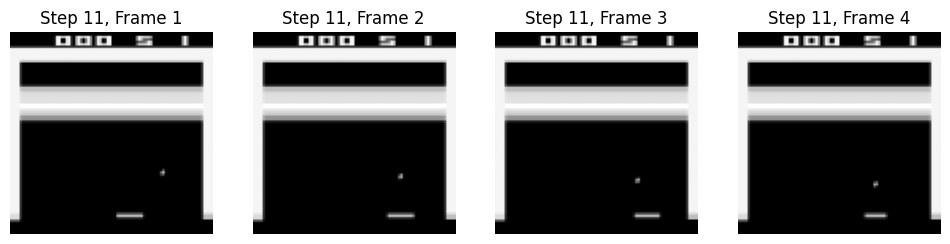

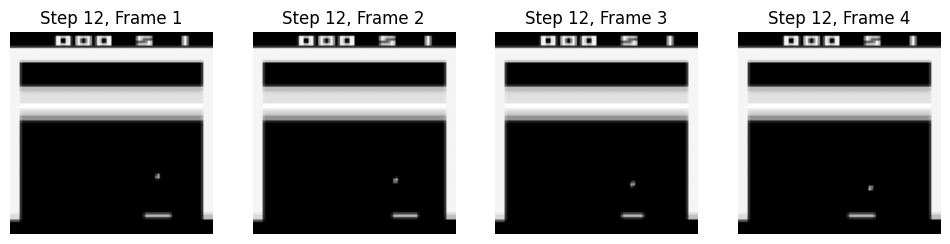

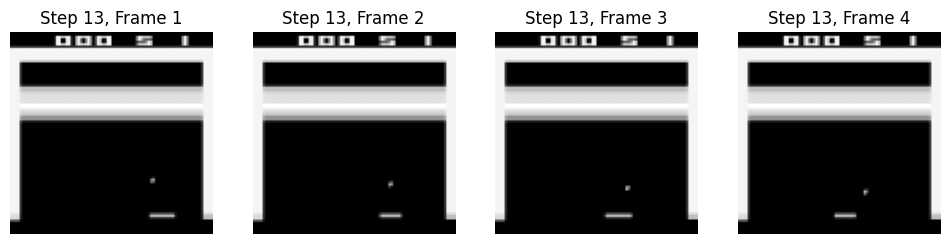

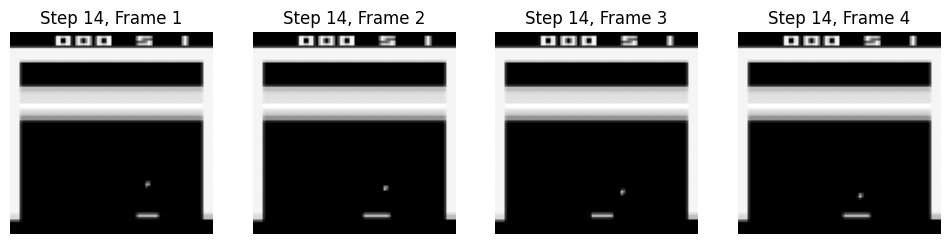

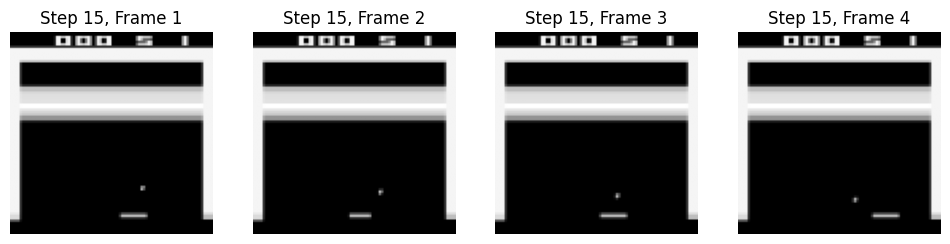

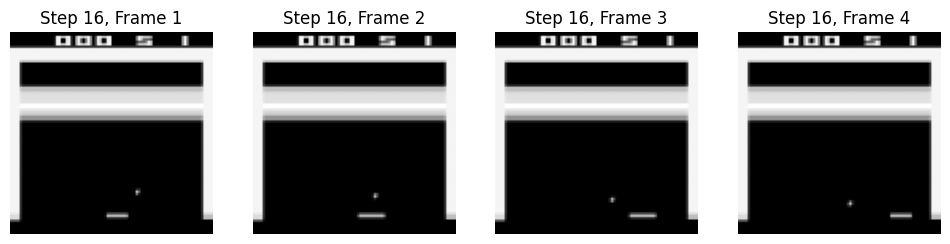

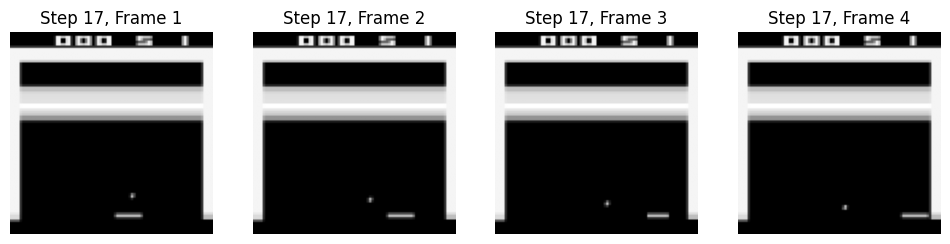

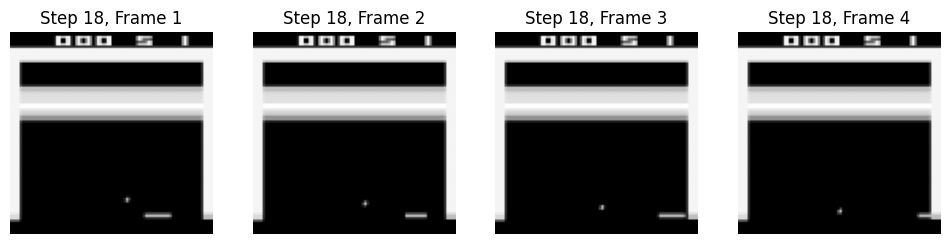

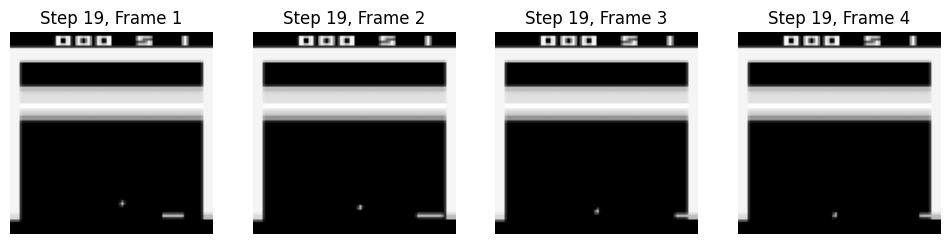

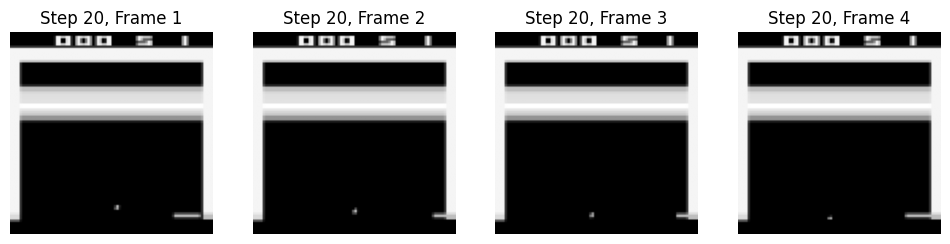

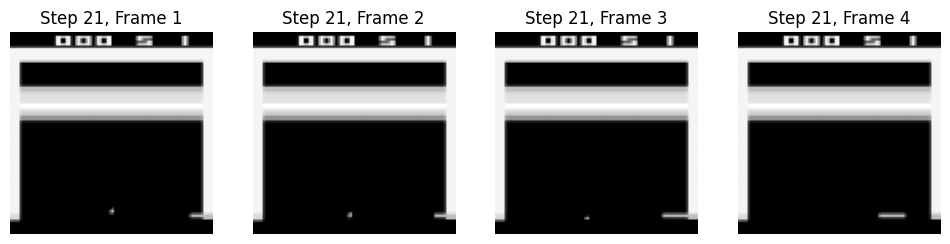

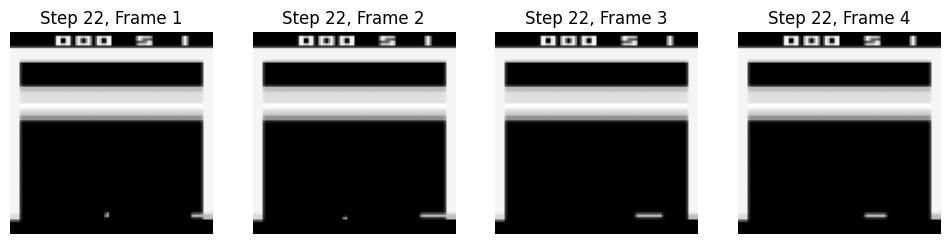

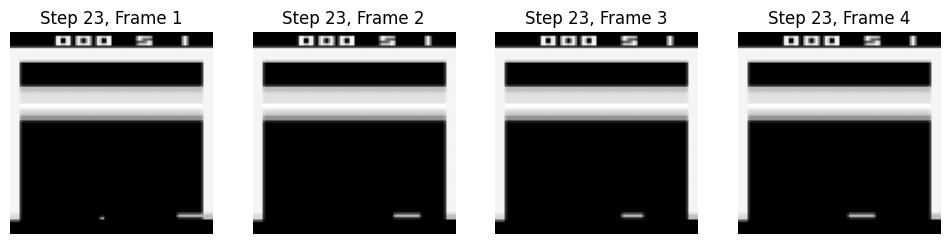

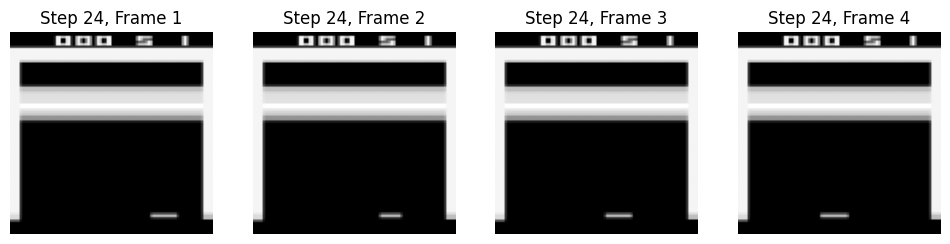

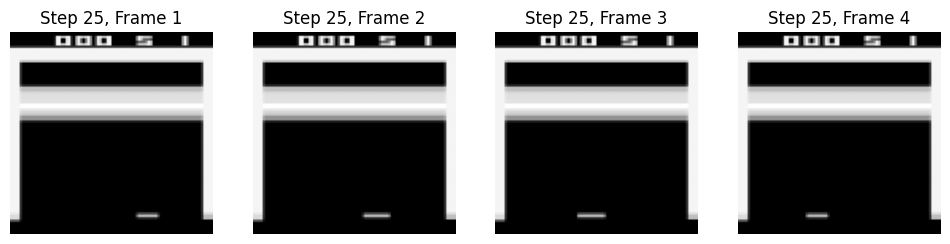

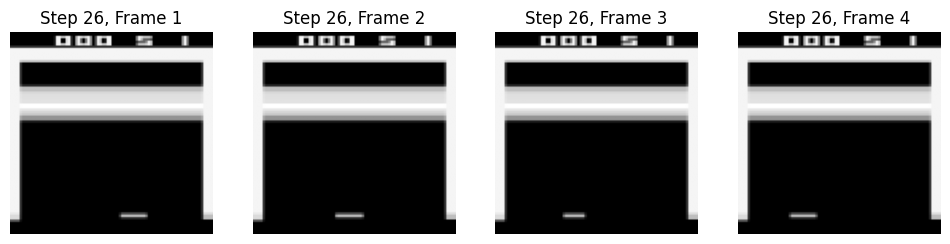

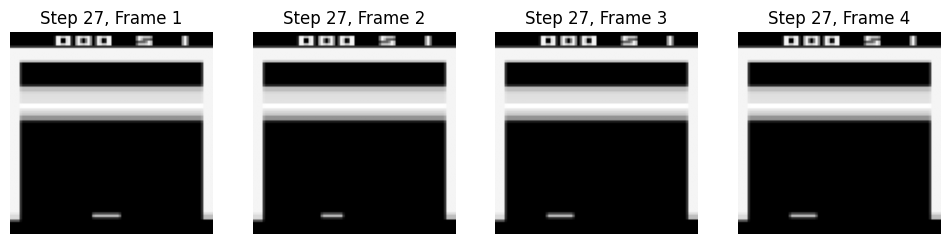

In [6]:
obs, info = env.reset()
frames = [obs]

total_reward = 0
for step in range(100):
    action = env.action_space.sample()  # random action
    obs, reward, done, truncated, info = env.step(action)

    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    for i in range(4):
        axes[i].imshow(obs[i, :, :], cmap='gray')
        axes[i].set_title(f'Step {step+1}, Frame {i+1}')
        axes[i].axis('off')
    plt.show()

    frames.append(obs)
    total_reward += reward
    if done or truncated:
        break

env.close()


In [7]:
Video("videos/breakout_test-episode-0.mp4", embed=True)

#SL

In [8]:
class MinariDataset(Dataset):
    def __init__(self, dataset, stack_size=4):
        obs = np.concatenate([ep.observations for ep in dataset], axis=0)
        obs = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in obs], dtype=np.float32)
        obs = np.array([cv2.resize(frame, (84, 84)) for frame in obs], dtype=np.float32)
        obs = obs / 255.0
        obs = (obs > 0.1).astype(np.float32)
        obs = (obs - 0.5) * 2

        obs = obs[:,8:,:]
        obs = obs[:,:,4:80]

        obs[:,:8,:] = 0.5

        self.obs = obs

        self.stack_size = stack_size
        self.max_idx = len(self.obs) - stack_size

    def __len__(self):
        return self.max_idx

    def __getitem__(self, idx):
          # --- Stack frames ---
          stack = self.obs[idx : idx + self.stack_size].copy()  # (stack_size, H, W)
          target = torch.tensor(stack, dtype=torch.float32)

          # --- Mask one random frame for input ---
          drop_idx = random.randint(0, self.stack_size - 1)
          masked_stack = stack.copy()
          masked_stack[drop_idx] = 0.0
          x = torch.tensor(masked_stack, dtype=torch.float32)

          # --- Compute difference frames ---
          # differences between consecutive frames: (stack_size-1, H, W)
          diff_stack = torch.tensor((stack[1:] - stack[:-1])/2 , dtype=torch.float32)

          return x, target, diff_stack

In [9]:
minari_dataset = minari.load_dataset('atari/breakout/expert-v0', download=True)
minari_dataset = MinariDataset(dataset = minari_dataset)
minari_dataloader = DataLoader(minari_dataset, batch_size=512, shuffle=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


namespace_metadata.json: 0.00B [00:00, ?B/s]

metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

breakout/expert-v0/data/main_data.hdf5:   0%|          | 0.00/70.3M [00:00<?, ?B/s]


Dataset atari/breakout/expert-v0 downloaded to /root/.minari/datasets/atari/breakout/expert-v0


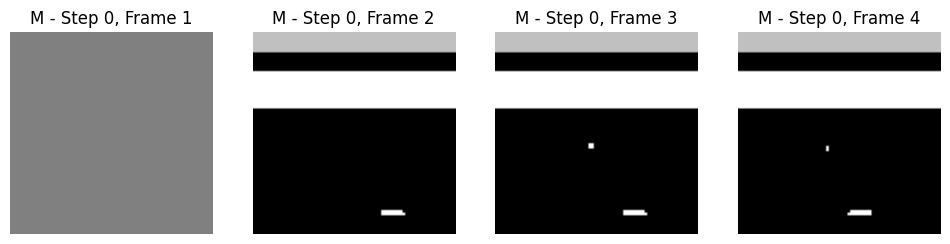

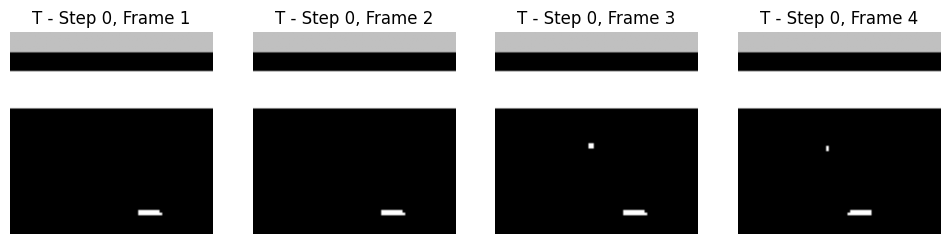

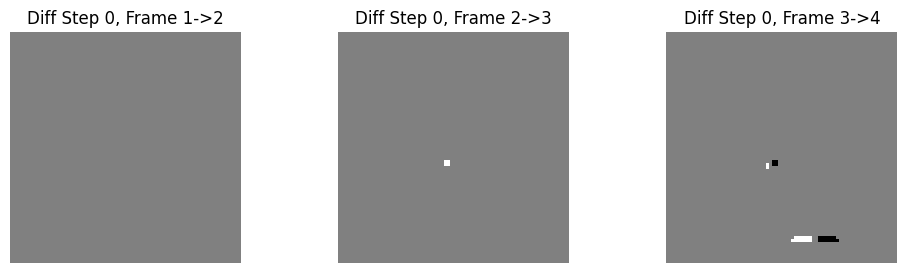

In [10]:
for j, (x, target, diff_stack) in enumerate(minari_dataset):
    # --- Masked input ---
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for i in range(4):
        axes[i].imshow(x[i, :, :], cmap='gray', vmin=-1, vmax=1)
        axes[i].set_title(f'M - Step {j}, Frame {i+1}')
        axes[i].axis('off')
    plt.show()

    # --- Target stack ---
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for i in range(4):
        axes[i].imshow(target[i, :, :], cmap='gray', vmin=-1, vmax=1)
        axes[i].set_title(f'T - Step {j}, Frame {i+1}')
        axes[i].axis('off')
    plt.show()

    # --- Difference frames (optional) ---
    fig, axes = plt.subplots(1, diff_stack.shape[0], figsize=(12, 3))
    for i in range(diff_stack.shape[0]):
        axes[i].imshow(diff_stack[i, :, :], cmap='gray', vmin=-1, vmax=1)
        axes[i].set_title(f'Diff Step {j}, Frame {i+1}->{i+2}')
        axes[i].axis('off')
    plt.show()

    if j >= 0:
        break


In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_channels=4, latent_dim=128):
        super().__init__()
        # --- Encoder ---
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)  # -> (32, 18, 18)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)             # -> (64, 8, 8)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)             # -> (64, 6, 6)
        self.fc1 = nn.Linear(6*6*64, latent_dim)

        # --- Decoder ---
        self.fc2 = nn.Linear(latent_dim, 6*6*64)
        self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1)  # -> (64, 8, 8)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)  # -> (32, 18, 18)
        self.deconv3 = nn.ConvTranspose2d(32, input_channels, kernel_size=8, stride=4)  # -> (4, 84, 84)

        # --- Difference Decoder ---
        # Predicts (stack_size-1) difference frames per input stack
        self.diff_fc2 = nn.Linear(latent_dim, 64*6*6)
        self.diff_deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1)
        self.diff_deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)
        self.diff_deconv3 = nn.ConvTranspose2d(32, input_channels-1, kernel_size=8, stride=4)


    def forward(self, x):

        # --- Encoder ---
        x_enc = F.leaky_relu(self.conv1(x))
        x_enc = F.leaky_relu(self.conv2(x_enc))
        x_enc = F.leaky_relu(self.conv3(x_enc))
        x_enc_flat = x_enc.view(x_enc.size(0), -1)
        latent = F.leaky_relu(self.fc1(x_enc_flat))

        # --- Full-frame Decoder ---
        x_dec = F.leaky_relu(self.fc2(latent))
        x_dec = x_dec.view(x_dec.size(0), 64, 6, 6)
        x_dec = F.leaky_relu(self.deconv1(x_dec))
        x_dec = F.leaky_relu(self.deconv2(x_dec))
        recon_full = torch.tanh(self.deconv3(x_dec))  # (B, 4, H, W)

        # --- Difference Decoder ---
        d_dec = F.leaky_relu(self.diff_fc2(latent))
        d_dec = d_dec.view(d_dec.size(0), 64, 6, 6)
        d_dec = F.leaky_relu(self.diff_deconv1(d_dec))
        d_dec = F.leaky_relu(self.diff_deconv2(d_dec))
        recon_diff = torch.tanh(self.diff_deconv3(d_dec))  # (B, 3, H, W)  (stack_size-1)

        return recon_full, recon_diff, latent

In [24]:
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

In [31]:
state_dict = torch.load("autoencoder_1.pth", map_location=device)
autoencoder.load_state_dict(state_dict)

<All keys matched successfully>

In [45]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 000 | Loss: 0.776813


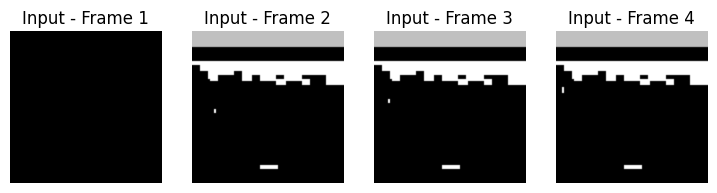

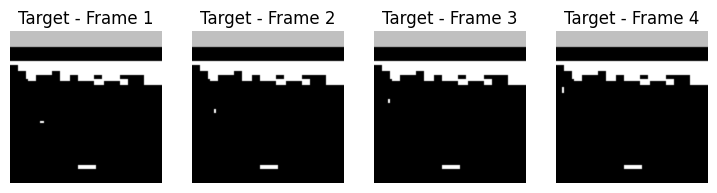

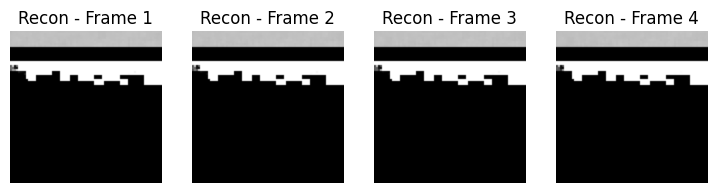

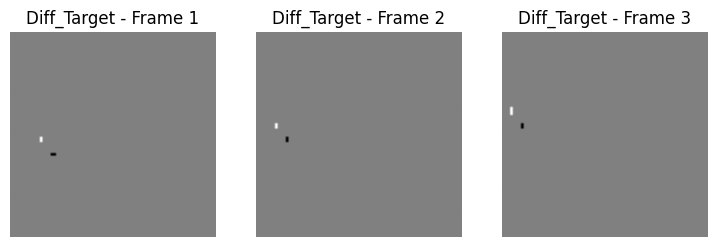

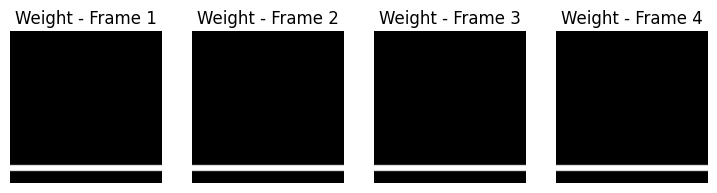

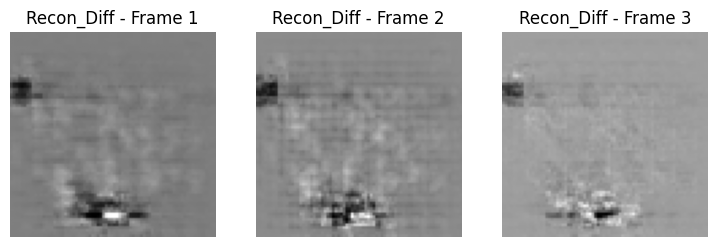

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 001 | Loss: 0.784013


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 002 | Loss: 0.778846


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 003 | Loss: 0.770870


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 004 | Loss: 0.768034


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 005 | Loss: 0.760685


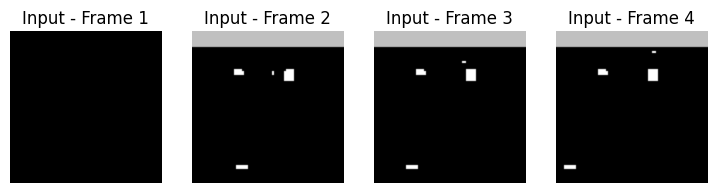

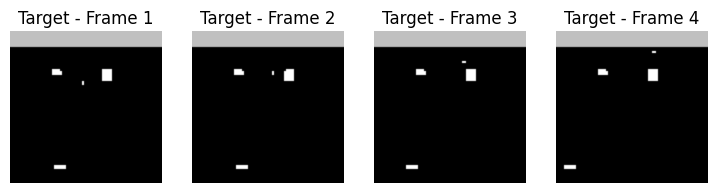

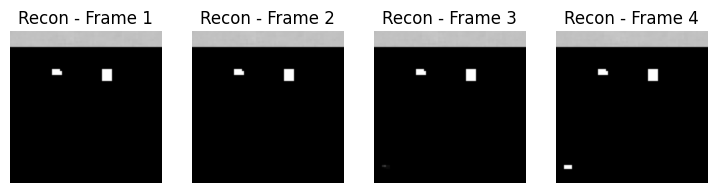

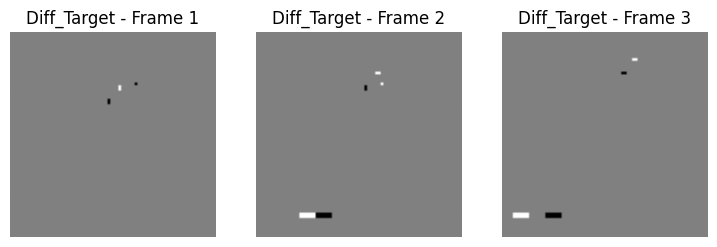

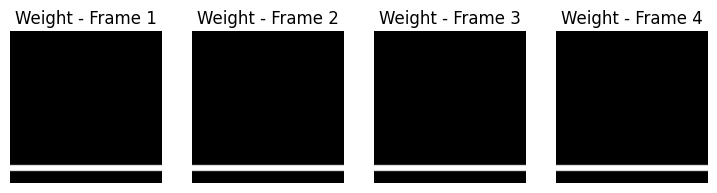

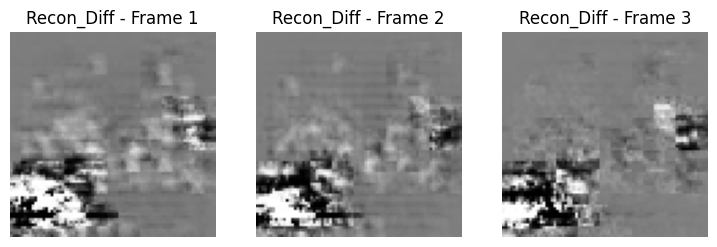

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 006 | Loss: 0.760344


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 007 | Loss: 0.758909


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 008 | Loss: 0.756238


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 009 | Loss: 0.754071


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 010 | Loss: 0.751690


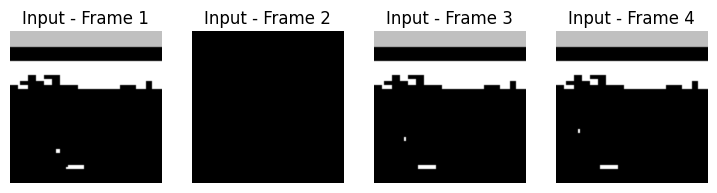

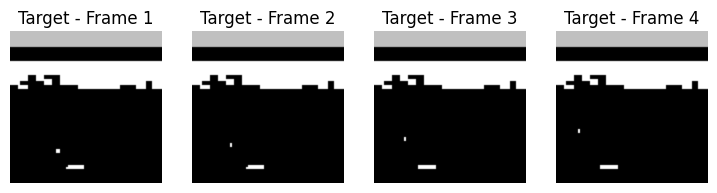

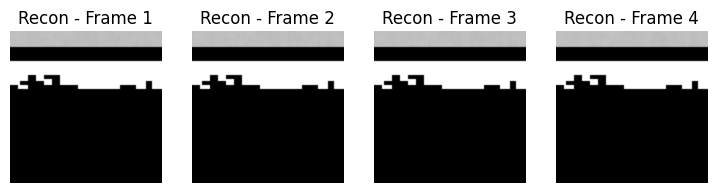

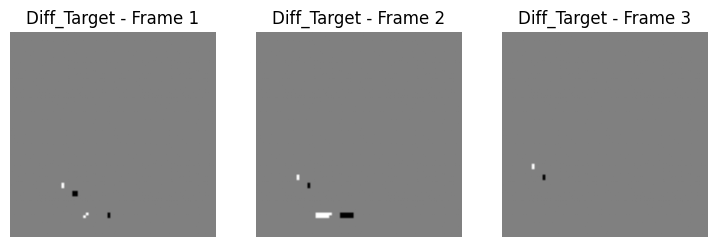

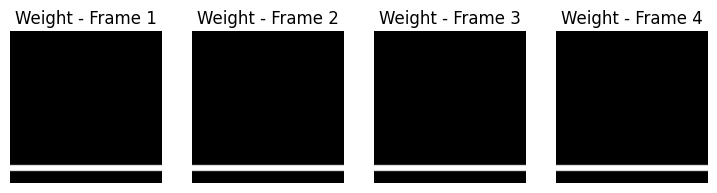

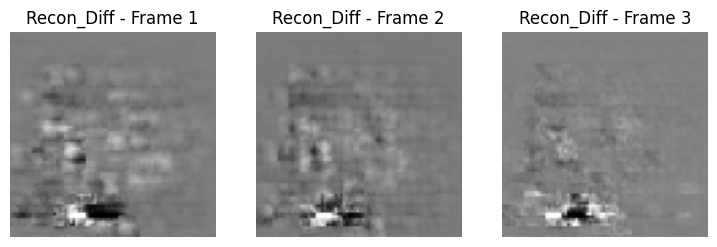

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 011 | Loss: 0.753951


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 012 | Loss: 0.749425


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 013 | Loss: 0.748671


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 014 | Loss: 0.747479


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 015 | Loss: 0.745804


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 016 | Loss: 0.743091


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 017 | Loss: 0.742480


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 018 | Loss: 0.744706


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 019 | Loss: 0.740534


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 020 | Loss: 0.740265


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 021 | Loss: 0.737389


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 022 | Loss: 0.740653


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 023 | Loss: 0.736996


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 024 | Loss: 0.736363


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 025 | Loss: 0.734177


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 026 | Loss: 0.732565


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 027 | Loss: 0.733297


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 028 | Loss: 0.731171


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 029 | Loss: 0.729125


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 030 | Loss: 0.728793


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 031 | Loss: 0.729251


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 032 | Loss: 0.728558


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 033 | Loss: 0.724777


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 034 | Loss: 0.725794


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 035 | Loss: 0.725357


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 036 | Loss: 0.724941


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 037 | Loss: 0.723214


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 038 | Loss: 0.723288


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 039 | Loss: 0.722071


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 040 | Loss: 0.724185


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 041 | Loss: 0.724371


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 042 | Loss: 0.720197


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 043 | Loss: 0.719297


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 044 | Loss: 0.719920


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 045 | Loss: 0.717672


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 046 | Loss: 0.716265


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 047 | Loss: 0.715382


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 048 | Loss: 0.713353


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 049 | Loss: 0.713486


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 050 | Loss: 0.711839


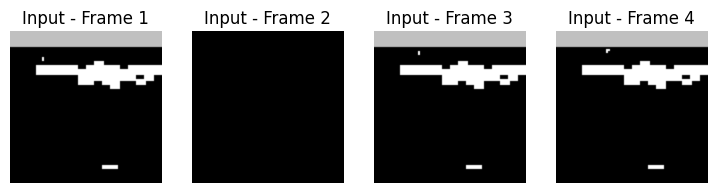

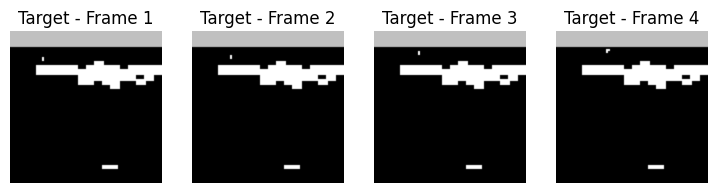

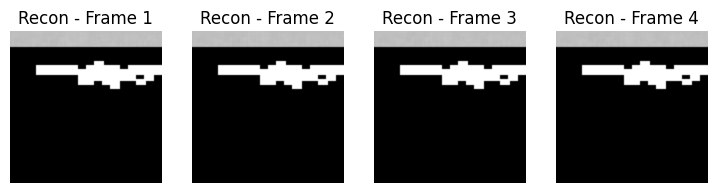

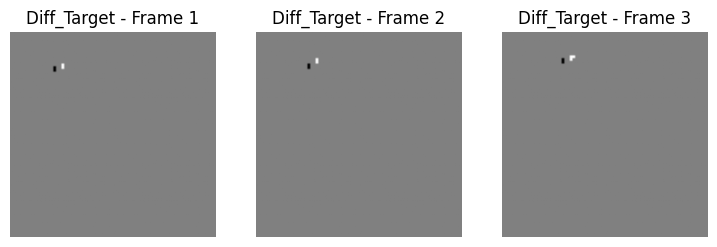

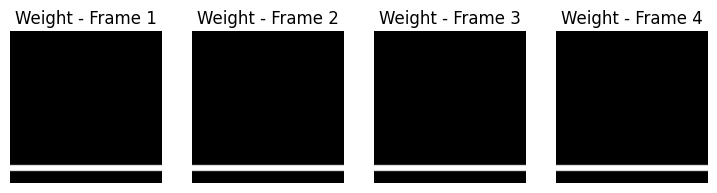

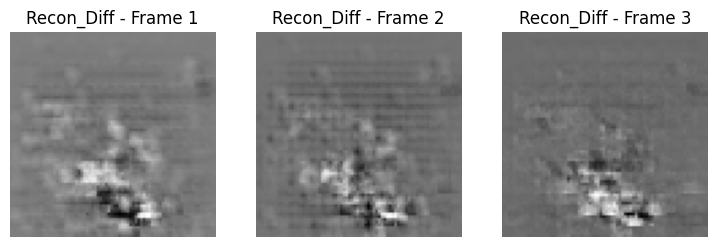

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 051 | Loss: 0.712833


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 052 | Loss: 0.711882


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 053 | Loss: 0.711452


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 054 | Loss: 0.707852


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 055 | Loss: 0.708813


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 056 | Loss: 0.707937


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 057 | Loss: 0.707841


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 058 | Loss: 0.707466


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 059 | Loss: 0.705343


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 060 | Loss: 0.707173


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 061 | Loss: 0.706674


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 062 | Loss: 0.704255


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 063 | Loss: 0.703269


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 064 | Loss: 0.703489


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 065 | Loss: 0.702265


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 066 | Loss: 0.701739


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 067 | Loss: 0.701400


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 068 | Loss: 0.699602


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 069 | Loss: 0.700854


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 070 | Loss: 0.695882


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 071 | Loss: 0.696554


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 072 | Loss: 0.696703


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 073 | Loss: 0.695486


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 074 | Loss: 0.696284


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 075 | Loss: 0.692733


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 076 | Loss: 0.694339


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 077 | Loss: 0.694940


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 078 | Loss: 0.693120


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 079 | Loss: 0.691184


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 080 | Loss: 0.690389


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 081 | Loss: 0.691216


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 082 | Loss: 0.689075


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 083 | Loss: 0.688814


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 084 | Loss: 0.687597


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 085 | Loss: 0.687488


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 086 | Loss: 0.685087


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 087 | Loss: 0.685567


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 088 | Loss: 0.682694


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 089 | Loss: 0.684756


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 090 | Loss: 0.684770


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 091 | Loss: 0.681851


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 092 | Loss: 0.681217


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 093 | Loss: 0.682727


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 094 | Loss: 0.681191


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 095 | Loss: 0.678672


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 096 | Loss: 0.680671


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 097 | Loss: 0.677237


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 098 | Loss: 0.678942


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 099 | Loss: 0.678479


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 100 | Loss: 0.676067


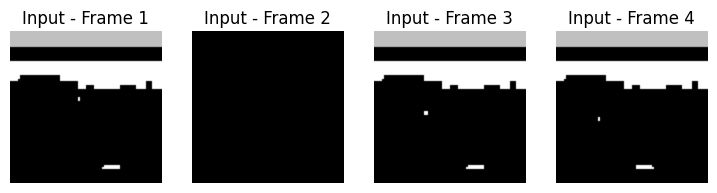

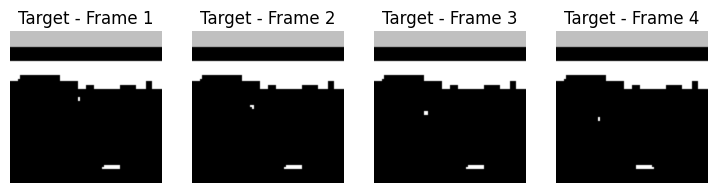

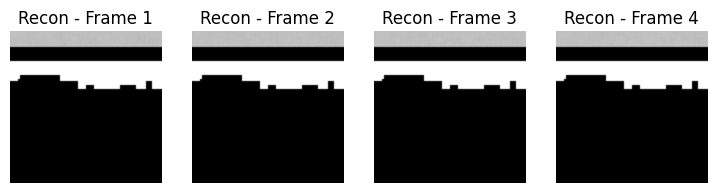

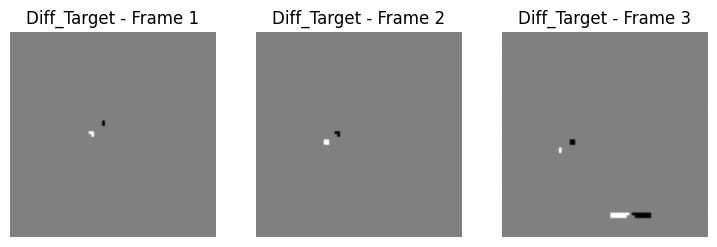

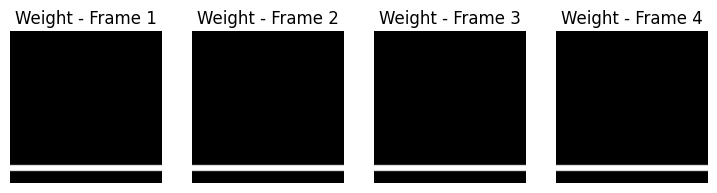

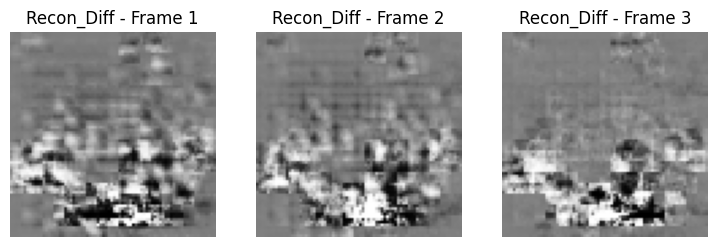

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 101 | Loss: 0.675078


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 102 | Loss: 0.676930


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 103 | Loss: 0.674640


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 104 | Loss: 0.674002


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 105 | Loss: 0.672151


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 106 | Loss: 0.672939


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 107 | Loss: 0.670924


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 108 | Loss: 0.671339


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 109 | Loss: 0.671275


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 110 | Loss: 0.669873


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 111 | Loss: 0.669757


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 112 | Loss: 0.669307


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 113 | Loss: 0.665260


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 114 | Loss: 0.665242


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 115 | Loss: 0.665439


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 116 | Loss: 0.667083


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 117 | Loss: 0.665485


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 118 | Loss: 0.665968


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 119 | Loss: 0.665692


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 120 | Loss: 0.663031


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 121 | Loss: 0.660446


  0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):

    autoencoder.train()
    total_loss = 0.0

    for input, target, diff_target in tqdm(minari_dataloader,leave=False):

        input, target, diff_target = input.to(device), target.to(device), diff_target.to(device)

        # --- Forward pass ---
        recon, recon_diff, _ = autoencoder(input)

        # --- Loss computation ---
        # Full-stack reconstruction

        loss = F.mse_loss(recon, target)

        pad_mask = torch.zeros_like(target)
        pad_mask[:, :, 67:70, :] = 1.0

        weight = torch.ones_like(target)
        weight = weight + pad_mask * 10

        weight = weight / weight.sum()



        loss_diff = ((recon - target)**2 * weight).sum()


        # Difference prediction with weighted loss

        weight_diff = (diff_target != 0).float()

        ball_mask = torch.zeros_like(weight_diff)
        ball_mask[:, :, 29:67, :] = 1.0
        ball_mask[:, :, 9:15, :] = 1.0

        weight_diff = weight_diff + 10 * weight_diff * ball_mask
        weight_diff = weight_diff + 0.01

        weight_diff = weight_diff / weight_diff.sum()


        loss_diff = ((recon_diff - diff_target)**2 * weight_diff).sum()

        # Total loss
        loss = loss + loss_diff

        # --- Backprop ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input.size(0)

    avg_loss = total_loss / len(minari_dataloader.dataset)
    print(f"Epoch {epoch:03d} | Loss: {avg_loss:.6f}")

    # --- Visualization / checkpointing ---
    if epoch % 50 == 0 or (epoch in [5, 10]):

        torch.save(autoencoder.state_dict(), f"autoencoder_{epoch:03d}.pth")

        shards = {"Input": input,
          "Target": target,
          "Recon": recon,
          "Diff_Target": diff_target,
          "Weight-Diff": weight_diff,
          "Recon_Diff": recon_diff
        }

        for key, value in shards.items():

          shard = value[0].cpu().detach().numpy()

          fig, axes = plt.subplots(1, shard.shape[0], figsize=(9, 3))
          for i in range(shard.shape[0]):
              axes[i].imshow(shard[i], cmap='gray')
              axes[i].set_title(f'{key} - Frame {i+1}')
              axes[i].axis('off')
          plt.show()


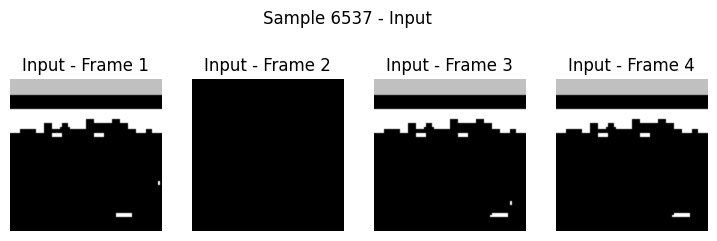

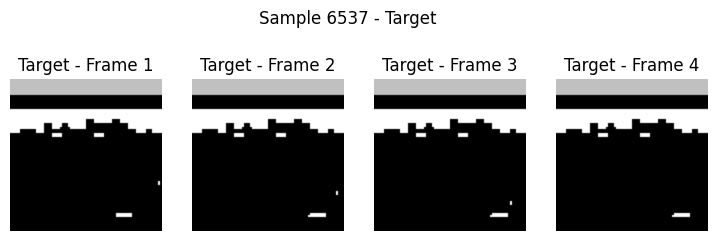

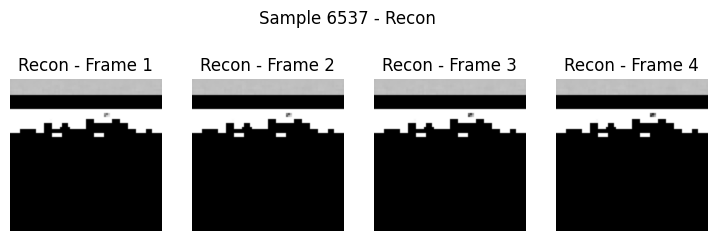

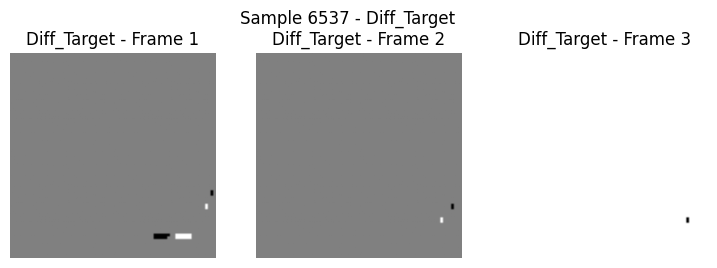

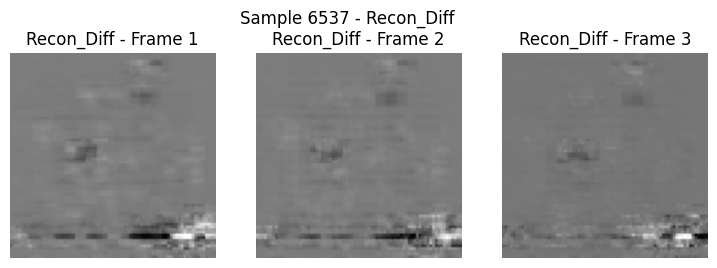

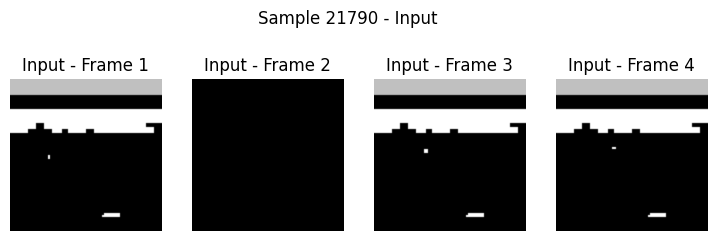

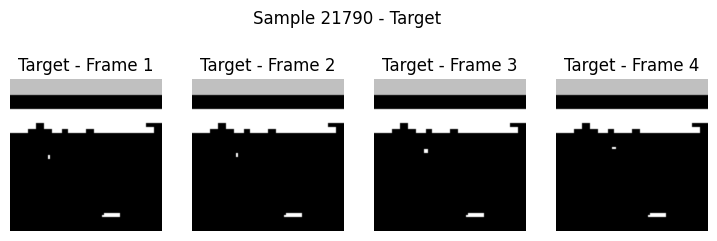

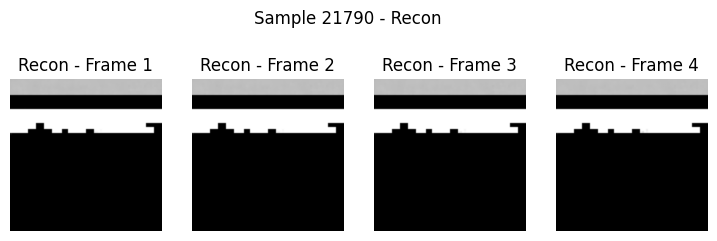

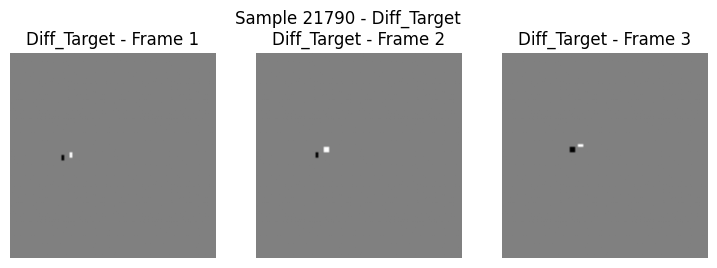

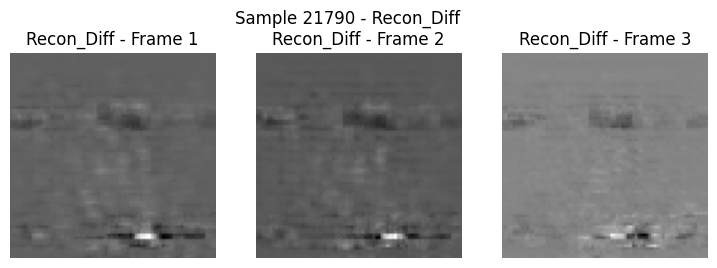

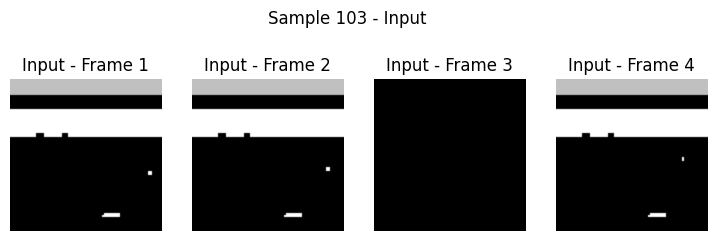

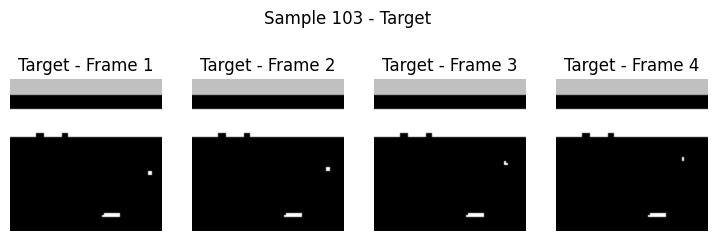

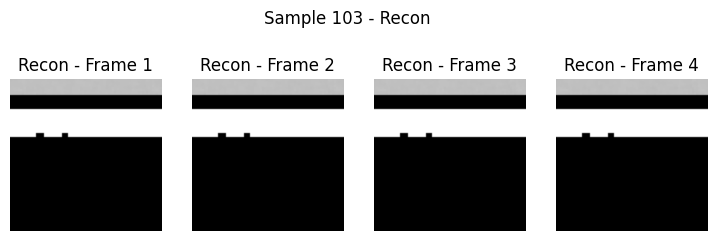

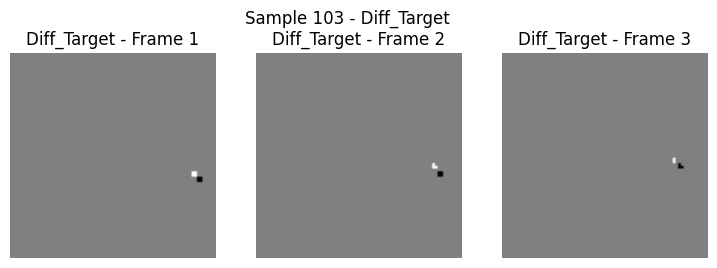

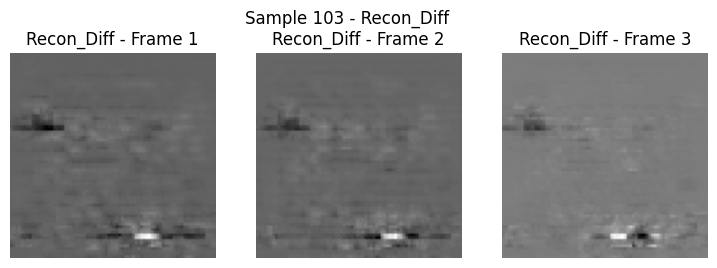

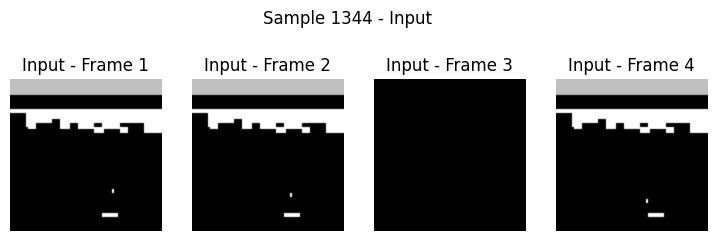

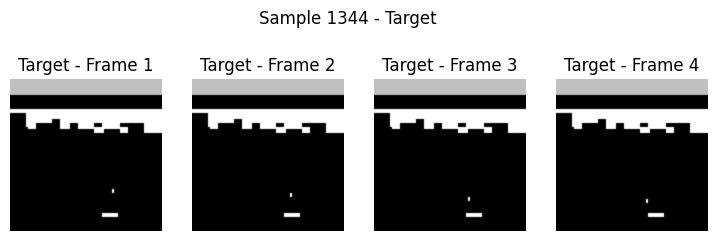

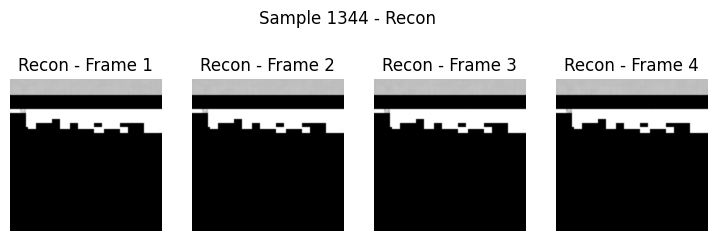

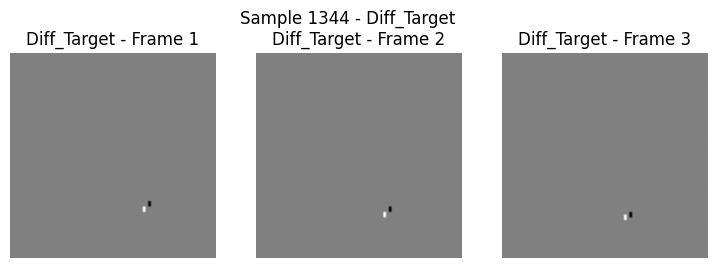

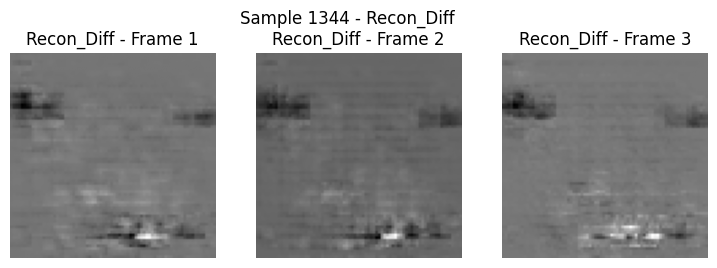

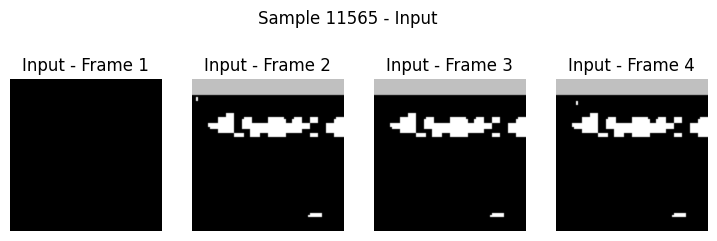

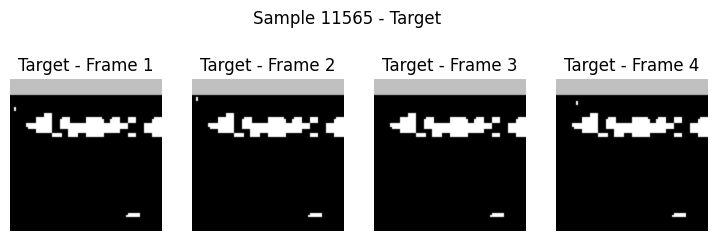

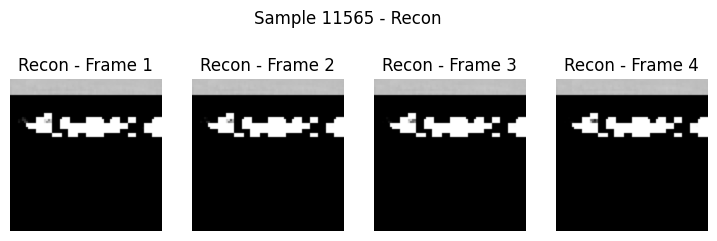

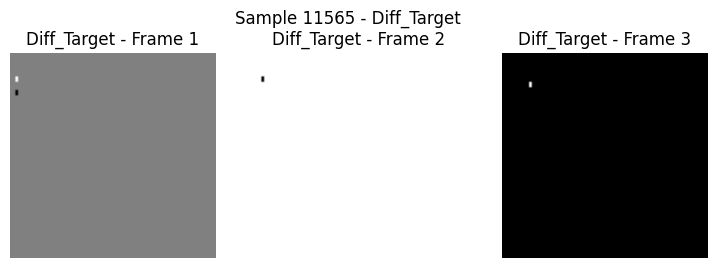

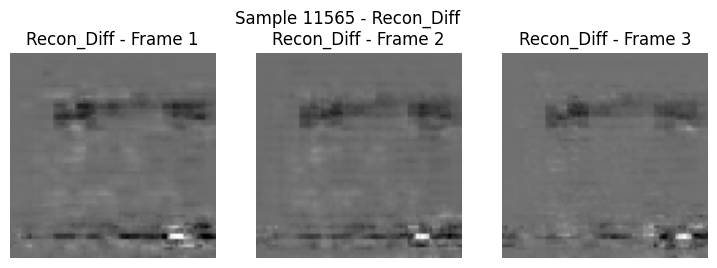

In [44]:
autoencoder.eval()
num_samples = 5  # number of samples to visualize
sample_indices = random.sample(range(len(minari_dataset)), num_samples)

for idx in sample_indices:
    input, target, diff_target = minari_dataset[idx]

    # Add batch dimension and move to device
    input = input.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        recon, recon_diff, _ = autoencoder(input)

    # Move tensors back to CPU for plotting
    input_np = input[0].cpu().numpy()
    target_np = target.cpu().numpy()
    recon_np = recon[0].cpu().numpy()
    diff_target_np = diff_target.cpu().numpy()
    recon_diff_np = recon_diff[0].cpu().numpy()

    # --- Plot ---
    shards = {
        "Input": input_np,
        "Target": target_np,
        "Recon": recon_np,
        "Diff_Target": diff_target_np,
        "Recon_Diff": recon_diff_np
    }

    for key, value in shards.items():
        fig, axes = plt.subplots(1, value.shape[0], figsize=(9, 3))
        for i in range(value.shape[0]):
            axes[i].imshow(value[i], cmap='gray')
            axes[i].set_title(f'{key} - Frame {i+1}')
            axes[i].axis('off')
        plt.suptitle(f'Sample {idx} - {key}')
        plt.show()

# RL

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_channels=4, num_actions=4):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7*7*64, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
q = DQN()
q_hat = DQN()
q_hat.load_state_dict(q.state_dict())

optimizer_q = torch.optim.Adam(q.parameters(), lr=0.001)

q = q.to(device)
q_hat = q_hat.to(device)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:

n_steps = 5e7
eps = 0.1
gamma = 0.99

training_steps_per_episode = 3

transitions = []

for episode_idx in tqdm(range(int(5e5))):

  transitions = []

  if n_steps < 0:
    break

  obs, info = env.reset()

  for step in tqdm(range(1, 1001)):

    if np.random.rand() < eps:
      action = env.action_space.sample()

    else:
      with torch.no_grad():
        q_values = q(torch.from_numpy(obs).unsqueeze(0).to(device))
        action = torch.argmax(q_values).item()

    obs_, reward, done, truncated, info = env.step(action)

    transitions.append((obs, action, reward, obs_, done, truncated))

    obs = obs_

    if done or truncated:
      n_steps -= step
      break


    for training_step_ids in range(training_steps_per_episode):

      transition = random.sample(transitions, 1)

      obs, action, reward, obs_, done, truncated = transition[0]

      q_values = q_hat(torch.from_numpy(obs_).unsqueeze(0).to(device))

      if done or truncated:
        y = reward
      else:
        y = reward + gamma * torch.max(q_values)

      loss = (y - q(torch.from_numpy(obs).unsqueeze(0).to(device))[0][action])**2
      optimizer_q.zero_grad()
      loss.backward()
      optimizer_q.step()

    if step % 100 == 0:
      q_hat.load_state_dict(q.state_dict())


In [ ]:
!mkdir videos/